In [1]:
using LinearAlgebra, CairoMakie, BenchmarkTools
import LsqFit

In [2]:
"""
    Fitter

Levenberg-Marquardt 1 variable least square fitting: minimize sum of weighted squared residuals

## Field

- f : function of independent variable x, and m coefficients, 'a', returning the simulated model: y_hat = func(t,a,c)
- p : initial guess of coefficient values                             (n x 1)
- xarr : independent variables (used as arg to func)                   (m x 1)
- yarr : data to be fit by func(t,p)                                   (m x 1)
- earr : weights or a scalar weight value ( weight >= 0 ) ...          (m x 1)
- Jacobian : Jacobian matrix used for inner calculation
- W : Weight matrix
- λ (1e-2) : L-M paramter
- Lup (11) : factor for increasing lambda
- Ldown (9) : factor for decreasing lambda
- MaxIter : allowded maximum number of iteration
- ϵ1 (1e-3) : convergence tolerance for gradient
- ϵ2 (1e-3) : convergence tolerance for coefficients
- ϵ3 (1e-1) : convergence tolerance for red. Chi-sqr
- ϵ4 (1e-1) : determines acceptance of a L-M step
- δ (1e-3) : for numerical calculation of jacobian.
"""

mutable struct Fitter
    f::Function
    p::AbstractVector{<:Real}
    xarr::AbstractVector{<:Real}
    yarr::AbstractVector{<:Real}
    earr::Union{Nothing, AbstractVector{<:Real}}
    J::Matrix{<:Real}
    W::Union{UniformScaling{<:Real}, AbstractMatrix{<:Real}}
    MaxIter::Int
    λ::Real
    Lup::Real
    Ldown::Real
    ϵ1::Real
    ϵ2::Real
    ϵ3::Real
    ϵ4::Real
    δ::Real
    convergence::Vector{Bool}
    Nitter::Int
    
    function Fitter(f, p0, xarr, yarr, earr=nothing; MaxIter = 1000, λ=1.0e-2, Lup=11.0, Ldown=9.9, ϵ1 = 1.0e-3, ϵ2=1.0e-3, ϵ3 = 1.0e-1, ϵ4=1.0e-1, δ = 1.0e-3)
        @assert length(xarr) == length(yarr)
        if earr != nothing 
            @assert length(xarr) == length(earr)
        end
        try
            f(xarr[1], p0)
        catch
            error("Unexpected behavior of function and parameters")
        end
        J0 = Matrix{Float64}(undef, (length(xarr), length(p0)))
        W = (earr === nothing) ? UniformScaling(1.0) : Matrix(Diagonal(1.0./(earr .* earr)))

        new(f, p0, xarr, yarr, earr, J0, W, MaxIter, λ, Lup, Ldown, ϵ1, ϵ2, ϵ3, ϵ4, δ, [false, false, false], 0 )
    end
end

function (ft::Fitter)(x)
    return ft.f(x, ft.p)
end

In [3]:

function update_jacobian!(lm::Fitter)

    @inbounds for j ∈ eachindex(lm.p), i ∈ eachindex(lm.xarr)
        p1, p2 = lm.p[:], lm.p[:]
        p1[j] += lm.δ
        p2[j] -= lm.δ
        lm.J[i, j] = (lm.f(lm.xarr[i], p1) - lm.f(lm.xarr[i], p2))/(2*lm.δ)
    end
end


# function update_jacobian!(lm::Fitter)

#     @inbounds for j ∈ eachindex(lm.p), i ∈ eachindex(lm.xarr)
#         p1 = lm.p[:]
#         p1[j] += lm.δ
#         # p2[j] -= lm.δ
#         lm.J[i, j] = (lm.f(lm.xarr[i], p1) - lm.f(lm.xarr[i], lm.p))/(2*lm.δ)
#     end
# end


function err(x::AbstractVector{<:Real}, y::AbstractVector{<:Real}, f::Function, p::AbstractVector)
    h(x) = f(x, p)
    return sum((y .- h.(x)).^2)
end

function err(lm::Fitter)
    return err(lm.xarr, lm.yarr, lm.f, lm.p)
end

function update_params(lm::Fitter, p)
    @assert length(p) == length(lm.p)
    lm.p = p
end

function calc_result(lm::Fitter)
    reducederr = err(lm::Fitter)/(length(lm.xarr) - length(lm.p))
    cov = inv((lm.J)' * (lm.J))
    err = sqrt.(diag(cov))
end

function fit(lm::Fitter, jacobian_kind=1)
    @assert jacobian_kind ∈ (1, 2)
    ee = err(lm)
    
    qs = 0.0
    update_jacobian!(lm)
    


    while lm.Nitter < lm.MaxIter
        lm.Nitter += 1
        
        Jt = Matrix(lm.J')              #Jt = J^T
        JtJ = Jt * lm.W * (lm.J)        #JtJ = J^T * W * J
        dD = Diagonal(diag(JtJ))
        dy =  lm.yarr .- [lm.f(t, lm.p) for t in lm.xarr]
        h = inv(JtJ + lm.λ * dD) * Jt * lm.W * dy
        ht = Matrix(h')
        err0 = err(lm)
        
        # 수렴 확인
        lm.convergence = [  maximum(abs.(Jt * lm.W * dy)) < lm.ϵ1, 
                            maximum(abs.(lm.p ./ h)) < lm.ϵ2,
                            err0/(length(lm.xarr) - length(lm.p)) < lm.ϵ3]

        if sum(lm.convergence) > 0
            break
        end

        dn = (ht * (lm.λ .* dD) * h) .+ Jt * lm.W * dy
        ρ = err0 - err(lm.xarr, lm.yarr, lm.f, lm.p .+ h)/norm(dn) 

        # update jacobian

        if jacobian_kind == 1 
            update_jacobian!(lm)
        else 
            lm.J = lm.J + ([lm.f(t, lm.p .+ h) - lm.f(t, lm.p) for t in lm.xarr] - (lm.J * h)) * ht ./dot(h, h)
        end

        if ρ > lm.ϵ4 
            lm.p = lm.p .+ h
            lm.λ = max(lm.λ/lm.Ldown, 1.0e-7)
        else 
            lm.λ = min(lm.λ*lm.Lup, 1.0e7)
        end
    end
    return (lm.p, lm.Nitter)
end

struct FitOutput
    p
    ep
    residual
end

function reduced_chisq(lm::Fitter)
    return  err(lm)/(length(lm.xarr) - length(lm.p))
end


function curve_fit(
    f::Function, 
    x::AbstractVector, 
    y::AbstractVector, 
    p0::AbstractVector;
    jacobian_kind::Int=1,
    output_level::Int=1,
    accuracy::Real=0,
    maxIteration::Integer = 1000)
    
    @assert accuracy ≥ 0
    @assert jacobian_kind ∈ (1, 2)
    @assert output_level ∈ (1, 2, 3)
    @assert maxIteration > 10

    fitobj = Fitter(f, p0, x, y, MaxIter = maxIteration)

    fitobj.ϵ1 *= 10.0^(-accuracy)
    fitobj.ϵ2 *= 10.0^(-accuracy)
    fitobj.ϵ3 *= 10.0^(-accuracy)
    fitobj.ϵ4 *= 10.0^(-accuracy)

    result = fit(fitobj, jacobian_kind)

    if output_level == 1
        return result
    
    elseif output_level == 2

    end
end

curve_fit (generic function with 1 method)

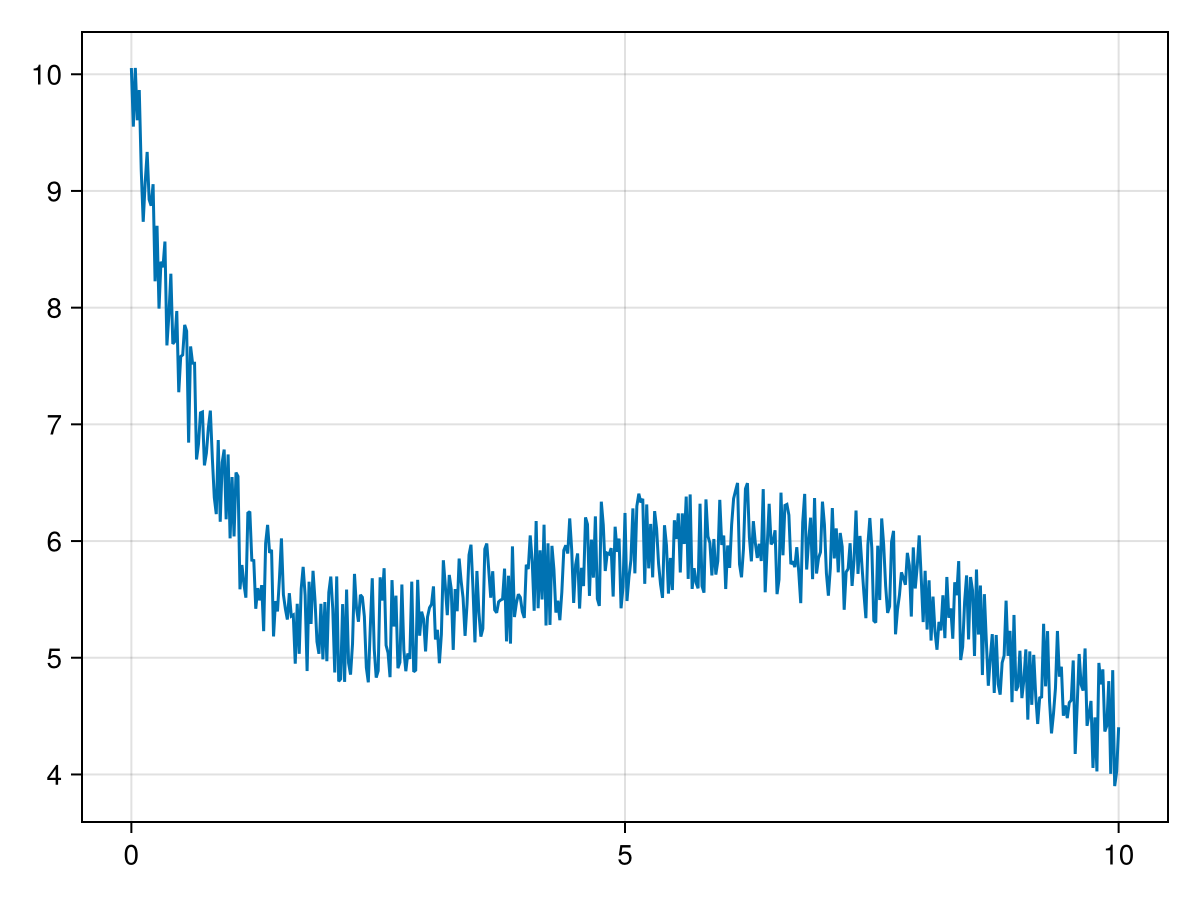

In [5]:
q(x, p) = p[1] * exp(-(x-p[2])^2/p[3]) + p[4]*exp(-x/p[5]) 
q2(x, p) = @. p[1] * exp(-(x-p[2])^2/50) + p[3]*exp(-x/p[4]) + p[5]
t=0.0:0.02:10.0
data = [q(x, [6.0, 6.0, 50.0, 7.0, 1.0]) for x in t]

data += (rand(length(data)).- 0.5)

lines(t, data)

In [22]:

# jacobian(q, t, [2.0, 1], 0.001)
p0 = [6.0, 6, 50.0, 5, 1]
lm = Fitter(q, [6.0, 6, 50.0, 5, 1], collect(t), data, MaxIter=100)

fit(lm)

([5.988930622950497, 6.0401461211845415, 48.2670168085364, 7.142720044609005, 1.0432296867142032], 2)

In [ ]:
lm = nFit(q, [2.0, 1.0, 5.0], t, data, MaxIter=100)
fit(lm, 1)

In [ ]:
reduced_chisq(lm)

In [ ]:
lm = nFit(q, [2.0, 1.0, 5.0], t, data, MaxIter=100)
fit(lm, 1)

In [ ]:
err(lm)

In [ ]:
@time curve_fit(q, t, data, [2.0, 1.0, 5.0],  maxIteration=100)

In [23]:
curve_fit(q, t, data, p0,  maxIteration=100)

([5.988930622950497, 6.0401461211845415, 48.2670168085364, 7.142720044609005, 1.0432296867142032], 2)

In [ ]:
@time lsq = LsqFit.curve_fit(q2, collect(t), data, [2.0, 1.0, 5.0])

In [ ]:
lsq.param

In [ ]:
typeof([true, true])

In [ ]:
sum([true, true])

In [ ]:
P = rand(1000, 5)
R = rand(1000, 1000)

In [ ]:
@btime (P')*R

In [ ]:
@btime begin
    PP = Matrix(P')
    PP*R
end

In [ ]:
X = P*P'
@btime Diagonal(diag(X))

In [ ]:
@btime Matrix(P')

In [ ]:
Matrix(P')

In [ ]:
@btime P*P'

In [ ]:
m, n = size(P)
A = Matrix{Float64}(undef, (m, m))
@btime begin
    mul!(A, P, P')
end

In [ ]:
A

In [ ]:
function tt(X, w)
    m, n = size(X)
    @assert m == size(w)[1]
    A = zeros(eltype(X), (n, n))
    @inbounds for j ∈ 1:n, i ∈ 1:n
        for k in 1:m
            @inbounds A[i, j] += w[k] * X[k, i] * X[k, j]
        end
    end
    return A
end

In [ ]:
w = collect(1:(size(P)[1]));

In [ ]:
@btime tt(P, w)

In [ ]:
@btime P'*Diagonal(w)*P

In [ ]:
size(w)